# ResNetの概要
ResNetはILSVRC-2015で1位のerror率3.57%のモデルである. これまでの経験から層を深くすると表現力が良くなり, 性能が良くなるということがわかっていた. しかし層が深すぎると最適化と近似計算の効率が良くならず, 浅いモデルのほうが性能が良くなってしまう現象(Degradation)が起きている. これを恒等写像の学習が難しいのではないか, という仮説の元, ResNetはResidual learningという手法を用いて恒等写像を基準に学習するモデルを採用した. またResNetの論文では初めてBatch NormalizationやHeの初期値についての記述がある.

Residual blockは次に示すように, 2つのConv layer(weight layer)とshortcut connection(恒等写像)からなる層のことである(図は論文から引用). Conv layerとshortcut connectionの結合時にshapeが異なることがあるが, これはConv layerの結果を無理矢理shortcut connectionのshapeに合わせるか, Conv layerのチャンネル数とstrideを調整することで解決する. このResidual blockを用いてlayerを1つの単位としてlayerを構成する手法がResidual learningである.

![Residual learning](./Residual_learning.png) 

ResnetにはResNet-34, Resnet-152という代表的なモデルがある. ここでは両方のモデルを紹介するが, 実装はResNet-34のみとする.ResNet-34およびResNet-152のモデルを次に示す. どちらのモデルにおいても, 各Residual blockの最初の層は`Stride=2`, 他の層は`Stride=1`である. 

**ResNet-34**

 <span style="color:green">Define of Redidual Block</span>  
1. input
2. Conv (3,3)
3. Conv (3,3)
4. add Conv's output and shortcut connection
5. output

<span style="color:green">Main model</span> 
- Input : (224,224,3)

 
- Conv1
    - Input (224,224,3)
    - Filter : (7,7,64)
    - Stride : 2


- Max Pooling
    - Filter : (3,3)
    - Stride : 2
    - Output : (56,56,64)


- Residual block x3
    - Channel : 64


- Residual block x4
    - Channel : 128


- Residual block x6
    - Channel : 256


- Residual block x3
    - Channel : 512


- Global Average Pooling


- Dense
    - Activation Softmax
    - Output : (1000)
    

**ResNet-152**

 <span style="color:green">Define of Redidual Block</span>  
1. input
2. Conv1
3. Conv2
4. Conv3
5. add Conv's output and shortcut connection
6. output

|Type|A|B|C|D|
:-:|:-:|:-:|:-:|:-:
|Conv1 : (1,1)|64|128|256|512|
|Conv2 : (3,3)|64|128|256|512|
|Conv3 : (1,1)|64|512|1024|2048|

<span style="color:green">Main model</span> 
- Input : (224,224,3)


- Conv1
    - Input : (224,224,3)
    - Filter : (7,7,256)
    - Stride : 2


- Max Pooling
    - Filter : (3,3)
    - Stride : 2
    - Output : (56,56,256)


- Res-A x3


- Res-Bx8


- Res-C x36


- Res-D x3


- Global Average Pooling
    - Dense
    - Activation : Softmax
    - Output : (1000)
    
Reference:
Deep Residual Learning for Image Recognition
https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

# ResNet-34の実装

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.layers import Add, GlobalAveragePooling2D
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

## ベースモデルの生成

In [3]:
def stem(inputs):
    """最初のConv,Pooling layerを追加する関数
    
    Args:
    inputs : 作成するモデル
    
    Returns:
    x : inputs modelにCov,Pooling layerを加えたモデル
    """
    
    x = Conv2D(64, kernel_size=(7, 7), activation="relu",strides=(2,2),padding="same",kernel_initializer=("he_normal"))(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2),padding="same")(x)
    return x

def learner(x):
    """residual learnig layerをまとめて追加する関数
    
    Args:
    x : 最初のConv,Poolingを追加したモデル
    
    Returns:
    x : residual learning layerを追加したモデル
    """
    # 64チャネルのresidual learnig layerを3つ追加
    x = residual_group(x,64,3)
    # 128チャネルのresidual learnig layerを4つ追加
    x = residual_group(x,128,3)
    # 256チャネルのresidual learnig layerを6つ追加
    x = residual_group(x,256,5)
    # 512チャネルのresidual learnig layerを3つ追加
    x = residual_group(x,512,2,False)
    return x

def residual_group(x,n_filters,n_blocks,conv=True):
    """residual learnig layerを追加する関数
    
    Args:
    x : residual leraning layerを追加するモデル
    n_filters : フィルターのチャネル数
    n_blocks : residual learingの層数
    conv : 畳み込み層を結合するかのフラグ
    
    Returns:
    x : residual learningを追加したモデル
    """
    for i in range(n_blocks): # nblock回iterate
        x = residual_block(x,n_filters) # residual blockを追加
        
    if conv:
        x = conv_block(x,n_filters*2)
    return x

def residual_block(x,n_filters):
    """residual blockを追加する関数
    
    Args:
    x : residual blockを追加するモデル
    n_filters : フィルターのチャネル数
    
    Returns:
    x : residual blockを追加したモデル
    """
    
    shortcut = x
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same",activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same",activation="relu", kernel_initializer="he_normal")(x)
    x = Add()([shortcut,x])
    return x

def conv_block(x,n_filters):
    """residual blockを追加する関数(Poolingなし)
    
    Args:
    x : residual blockを追加するモデル
    n_filters : フィルターのチャネル数
    
    Returns:
    x : residual blockを追加したモデル
    """
    shortcut = x
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same",activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same",activation="relu", kernel_initializer="he_normal")(x)
    return x   

def classifier(x,n_classes):
    """Global Average Pooling, Dense layerを追加する関数
    
    Args:
    x : Global Average Pooling, Dense layerを追加するモデル
    n_classes : 出力層の数
    
    Returns:
    outputs : Global Average Pooling, Dense layerを追加したモデル
    """
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(n_classes,activation="softmax",kernel_initializer="he_normal")(x)
    return outputs

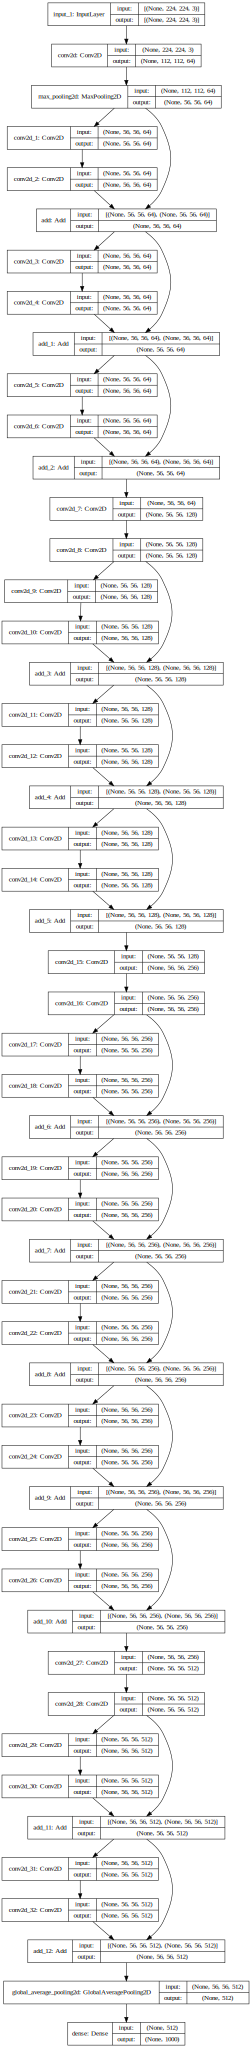

In [4]:
inputs =  Input(shape=(224,224,3))
x = stem(inputs)
x = learner(x)
outputs = classifier(x, 1000)
model = Model(inputs, outputs)

SVG(model_to_dot(model, show_shapes=True, dpi=None).create(prog='dot', format='svg'))

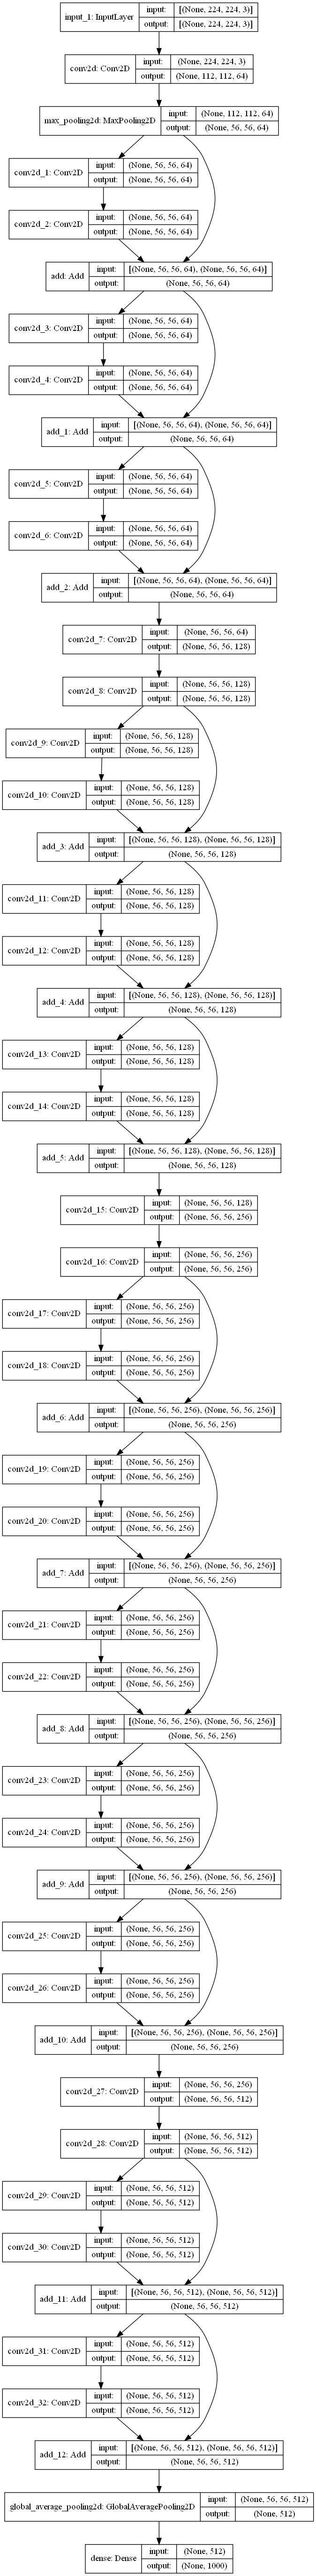

In [5]:
# モデルを画像として出力
from keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='ResNet-34.png')

## CIFAR-10による検証
CIFAR-10データを用いてResNetの精度検証を行う. 上のセルで作成したモデルの入力と,出力のサイズを調整することでCIFAR-10データに適応する.

In [4]:
# load CIFAR-10
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

In [5]:
# model 作成
inputs =  Input(shape=(224,224,3))
x = stem(inputs)
x = learner(x)
outputs = classifier(x, 10)
model = Model(inputs, outputs)

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen=ImageDataGenerator()

train_datagen.fit(x_train)
validation_datagen.fit(x_valid)

train_generator=train_datagen.flow(
    x_train,y_train,
    batch_size=100,
    shuffle=True
)

validation_generator=validation_datagen.flow(
    x_valid,y_valid,
    batch_size=100,
    shuffle=True
)

hist=model.fit_generator(train_generator,
                         epochs=100,
                         verbose=1,
                         validation_data=validation_generator)

C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
400/400 [==============================] - 42s 94ms/step - loss: 108.6542 - accuracy: 0.1019 - val_loss: 2.1201 - val_accuracy: 0.1769
Epoch 2/100
400/400 [==============================] - 38s 95ms/step - loss: 2.0168 - accuracy: 0.2175 - val_loss: 1.7784 - val_accuracy: 0.3124
Epoch 3/100
400/400 [==============================] - 37s 92ms/step - loss: 1.7836 - accuracy: 0.3113 - val_loss: 1.6432 - val_accuracy: 0.3641
Epoch 4/100
400/400 [==============================] - 37s 93ms/step - loss: 1.6543 - accuracy: 0.3731 - val_loss: 1.5304 - val_accuracy: 0.4338
Epoch 5/100
400/400 [==============================] - 37s 93ms/step - loss: 1.5813 - accuracy: 0.4092 - val_loss: 1.4843 - val_accuracy: 0.4560
Epoch 6/100
400/400 [==============================] - 37s 93ms/step - loss: 1.5124 - accuracy: 0.4418 - val_loss: 1.4490 - val_accuracy: 0.4729
Epoch 7/100
400/400 [==============================] - 37s 93ms/step - loss: 1.4583 - accuracy: 0.4651 - val_loss: 1.3592 - val_

In [7]:
def plot_loss(history):
    """エポックごとの損失関数をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    # 損失関数の履歴を取得
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    # 損失関数をプロット
    epochs=range(1,len(history.history["loss"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs,loss_train,label="Training loss")
    plt.plot(epochs,loss_val,label="Validation loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
def plot_acc(history):
    """エポックごとの正解率をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,len(history.history["accuracy"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

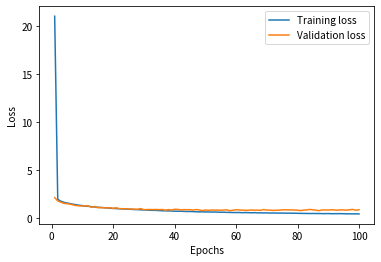

In [8]:
# 損失関数の描画
plot_loss(hist)

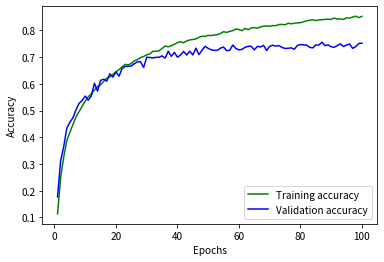

In [9]:
# 正解率を描画
plot_acc(hist)

In [10]:
# modelの評価
test_datagen=ImageDataGenerator()
test_datagen.fit(x_test)
test_generator=test_datagen.flow(
    x_test,y_test,
    batch_size=100,
    shuffle=True
)

scores = model.evaluate(test_generator)

100/100 [==============================] - 3s 28ms/step - loss: 0.8457 - accuracy: 0.7564
